In [1]:
%matplotlib inline
import json
import glob
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
import torch.optim as optim
import random
from joblib import Parallel, delayed
import torch.nn as nn
from shapely.geometry.polygon import Polygon
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import matplotlib.image as mpimg
import matplotlib.path as mplpath
import torch.nn.functional as F

In [2]:
def load_info(file_path):    
    with open(file_path) as json_file:
        data = json.load(json_file)
    list_of_train_data = [image['image_id']+'.jpg' for image in data['train']]    
    return list_of_train_data

loaded_image_ids = load_info('/scratch/lt2326-h21/a1/info.json')

In [3]:
def filter_images(train_json_path, images_folder):
    with open(train_json_path) as train_json:
        training_metadata = [json.loads(x) for x in train_json]
    training_metadata_filenames = [item['file_name'] for item in training_metadata]
    all_images = [image.split('/')[-1] for image in glob.glob(images_folder +'*.jpg')]
    intersection_train_info = set(loaded_image_ids).intersection(training_metadata_filenames) 
    wanted_data = [image_name for image_name in all_images if image_name in intersection_train_info]    
    wanted_metadata = [image for image in training_metadata if image['file_name'] in wanted_data]    
    return wanted_metadata

In [4]:
filtered_images = filter_images('/scratch/lt2326-h21/a1/train.jsonl','/scratch/lt2326-h21/a1/images/')


In [5]:
train, test = train_test_split(filtered_images, train_size=0.8)
test, val = train_test_split(test, train_size=0.5)

In [7]:
def get_bounding_boxes_info(filtered_images):
    
    dic = {}    
    for image in filtered_images:
        image_id = image['image_id']
        annotations = image['annotations']        
        l = []
        for annotation in annotations:
            if annotation[0]['is_chinese']:
                l.append(annotation[0]['polygon'])               
        dic[image_id] = l
                
    return dic
train_dic, test_dic, val_dic = get_bounding_boxes_info(train), get_bounding_boxes_info(test), get_bounding_boxes_info(val)


In [8]:

grid = np.array([[[a,b] for b in list(range(2048))] for a in list(range(2048))])
grid = grid.reshape(2048*2048, 2)

def load_imagenlabel(dic, image):
    # loads one image at a time as an array along with an array that shows whether the pixel was in a Chinese character bounding box or not 
    image_name = f'/scratch/lt2326-h21/a1/images/{image}.jpg'
    image_array = np.array(Image.open(image_name))   
    all_polygons = [polygon for polygon in dic[image]]
    
    
    truth_array = np.zeros(grid.shape[0])
    for polygon in all_polygons:
        p2 = mplpath.Path(polygon)
        truth = np.array(p2.contains_points(grid), int)
        truth_array = np.maximum(truth_array, truth)

    return (image_array, truth_array)


train_tensors = Parallel(n_jobs=10)(delayed(load_imagenlabel)(train_dic, image) for image in train_dic)
val_tensors = Parallel(n_jobs=10)(delayed(load_imagenlabel)(val_dic, image) for image in val_dic)
test_tensors = Parallel(n_jobs=10)(delayed(load_imagenlabel)(test_dic, image) for image in test_dic)


In [9]:
# Loading the Data
train_loader = DataLoader(train_tensors, batch_size = 4, shuffle = True)
test_loader = DataLoader(test_tensors, batch_size = 4, shuffle = True)
val_loader = DataLoader(val_tensors, batch_size = 4, shuffle = True)

In [10]:
# Hyperparameters
device = torch.device('cuda:0')
batch_size = 4  
learning_rate = 0.0001
epochs = 3

## MODEL 1

In [11]:
class Lenet(nn.Module):
    def __init__(self):
        super(Lenet, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=5),
            nn.Conv2d(in_channels=5, out_channels=10, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=3),
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(5,5)),
            nn.AvgPool2d(kernel_size=3),
            nn.ReLU()            
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=43*43*12, out_features=500),
            nn.ReLU(),
            nn.Linear(in_features=500, out_features=500//2),
            nn.Sigmoid()
        )        
    
    def forward(self, x):
        x = self.feature_extractor(x) 
        output = self.classifier(x)
        return output
    


## MODEL 2

In [12]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()        
        self.feature_extractor = nn.Sequential(            
            # first conv
            nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=5, out_channels=5, kernel_size=3, stride=1),
            nn.ReLU(),      
            nn.MaxPool2d(kernel_size=3),
            # second conv
            nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1),
            nn.ReLU(),             
            nn.MaxPool2d(kernel_size=3),
            # third conv
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1),
            nn.ReLU(),  
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1),
            nn.ReLU(),             
            nn.MaxPool2d(kernel_size=3),
            # fourth conv
            nn.Conv2d(in_channels=12, out_channels=15, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=3, stride=1),
            nn.ReLU(), 
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=3, stride=1),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=3),          
            # fifth conv
            nn.Conv2d(in_channels=15, out_channels=18, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=18, out_channels=18, kernel_size=3, stride=1),
            nn.ReLU(),    
            nn.Conv2d(in_channels=18, out_channels=18, kernel_size=3, stride=1),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=3)
            
        )
    
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=18*5*5, out_features=500),
            nn.ReLU(),
            nn.Linear(in_features=500, out_features=500//2),
            nn.ReLU(),
            nn.Linear(in_features=250, out_features=250//2),
            nn.Sigmoid()
        )    
            
    def forward(self, x):
        x = self.feature_extractor(x) 
        output = self.classifier(x)
        return output
    


In [13]:

def train(train_loader, model, epochs, device, model_num, output_size):    
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()
    model.train()
    print('Training')
    for e in range(epochs):
        total_loss = 0
        for i , (image_tensors, y_tensors) in enumerate(train_loader):
            image_tensors = image_tensors.permute(0,3,2,1).float()
            (image_tensors, y_tensors) = (image_tensors.to(device), y_tensors.to(device))
            output = model(image_tensors)
    
            upsampling_alg = nn.Upsample(size=2048*2048)
            upsampled_img = upsampling_alg(output.reshape(len(image_tensors), 1, output_size))
            
            loss = criterion(upsampled_img.reshape(len(image_tensors), 2048*2048), y_tensors.float())
            total_loss += loss.item()
            print(total_loss/(i+1), end='\r')            
            loss.backward() 
            optimizer.step() 
            optimizer.zero_grad()
        print(f'Finished training epoch {e+1}')
    print(f'Saving model{model_num}')
    # save model
    torch.save(model, f"model{model_num}.pt")

leNet = Lenet()
vgg = VGG16()
train(train_loader, leNet, epochs, device, '1',250)
train(train_loader, vgg, epochs, device, '2',125)

Training
Finished training epoch 1
Finished training epoch 2
Finished training epoch 3
Saving model1
Training


/usr/local/lib64/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Finished training epoch 1
Finished training epoch 2
Finished training epoch 3
Saving model2


In [14]:
# load saved models if we want to skip training
leNetModel = torch.load("model1.pt")
vggModel = torch.load("model2.pt")

In [15]:
def test(test_loader, model, device, output_size):
    model = model.to(device)
    mse = nn.MSELoss()
    total_loss = 0
    test_acc = 0

    model.eval()
    for i, (image_tensors, y_tensors) in enumerate(test_loader):
        image_tensors = image_tensors.permute(0,3,2,1).float()
        (image_tensors, y_tensors) = (image_tensors.to(device), y_tensors.to(device))
        
        with torch.no_grad():
            output = model(image_tensors)            
            
        upsampling_alg = nn.Upsample(size=2048*2048)
        upsampled_img = upsampling_alg(output.unsqueeze(0))
        
        loss = mse(upsampled_img.squeeze(), y_tensors)
        total_loss += loss.item()
        
        test_acc += torch.sum(torch.eq(torch.argmax(upsampled_img, dim=1), y_tensors))

    accuracy = int(test_acc) / ((i+1) * batch_size * 3*2048*2048)

    print(f'Accuracy: {round(accuracy,2)}, Loss: {round(total_loss,2)}')
    

In [16]:
test(val_loader, leNetModel, device, 250)
test(val_loader, vggModel, device, 125)


/usr/local/lib64/python3.9/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 4194304])) that is different to the input size (torch.Size([4194304])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Accuracy: 0.1, Loss: 0.03
Accuracy: 0.03, Loss: 0.02


In [17]:
test(test_loader, leNetModel, device, 250)
test(test_loader, vggModel, device, 125)

Accuracy: 0.11, Loss: 0.03
Accuracy: 0.04, Loss: 0.03


In [18]:
def visualise_unique_image(model, img_tensors, output_size):
    random_img_tensor = random.choice(img_tensors)
    random_img = torch.tensor(random_img_tensor[0])    
    reshaped_img_tensor = random_img.permute((2, 0, 1)).unsqueeze(0).float().to(device)
    
    with torch.no_grad():
        output = model(reshaped_img_tensor)        
       
    upsampling_alg = nn.Upsample(size=2048*2048)
    upsampled_img = upsampling_alg(output.reshape(1,1,output_size))
    probs = upsampled_img.reshape(2048,2048).squeeze()
    probs_array = np.array(probs.cpu())
    
    #plt.figure()
    plt.imshow(random_img)
    plt.imshow(probs_array, alpha=0.5)

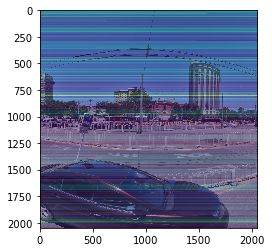

In [19]:
visualise_unique_image(leNet, test_tensors, 250)

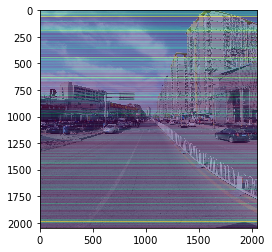

In [20]:
visualise_unique_image(leNet, test_tensors, 250)

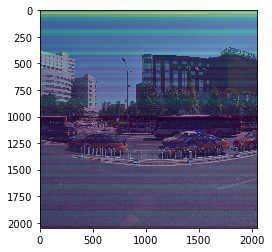

In [21]:
visualise_unique_image(vggModel, test_tensors,125)

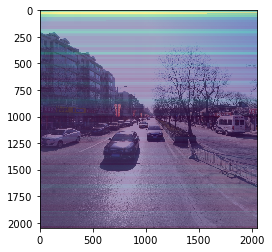

In [22]:
visualise_unique_image(vggModel, test_tensors,125)